In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
%matplotlib inline

In [3]:
metadata.head()

,Name,Exchange,Category,Sector
Symbol,,,,
^GSPC,S&P 500,SNP,Index,NaN
^DJI,Dow Jones Industrial Average,DJI,Index,NaN
AAPL,Apple Inc.,NMS,Electronic Equipment,Consumer Goods
BAC,Bank of America Corporation,NYQ,Money Center Banks,Financial
AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,Services


In [4]:
# Use Adjusted Clsoing Prices
data[['AAPL','MSFT','AMZN','^GSPC','^DJI']].head()

,AAPL,MSFT,AMZN,^GSPC,^DJI
Date,,,,,
2015-01-02,103.074181,43.134731,308.519989,2058.199951,17832.99023
2015-01-05,100.170410,42.738068,302.190002,2020.579956,17501.65039
2015-01-06,100.179840,42.110783,295.290009,2002.609985,17371.64063
2015-01-07,101.584595,42.645817,298.420013,2025.900024,17584.51953
2015-01-08,105.487686,43.900375,300.459991,2062.139893,17907.86914


In [5]:
returns = np.log(data / data.shift(1))[1:]

train = returns[:len(returns)-252]
test = returns[len(returns)-252:]
corr = train.corr()

In [6]:
# Contruct the Network

stocks = list(returns.columns)

G = nx.Graph()
G.add_nodes_from(stocks)
for stock in stocks:
    G.node[stock]['Name'] = metadata.loc[stock, 'Name']
    G.node[stock]['Exchange'] = metadata.loc[stock, 'Exchange']
    G.node[stock]['Industry'] = metadata.loc[stock, 'Category']
    G.node[stock]['Sector'] = metadata.loc[stock, 'Sector']

for first_stock in stocks:
    for second_stock in stocks[stocks.index(first_stock):]:
        if first_stock == second_stock:
            pass
        elif corr.loc[first_stock, second_stock] > 0.5:
            G.add_edge(first_stock, second_stock, weight=corr.loc[first_stock, second_stock])

In [7]:
deg_cent = pd.Series(nx.degree_centrality(G))
between_cent = pd.Series(nx.betweenness_centrality(G))
closeness_cent = pd.Series(nx.closeness_centrality(G))

cent = pd.concat([deg_cent, between_cent, closeness_cent], axis=1)
cent.columns = ['D_cent','B_cent','C_cent']

# Normalize the centralities using min-max
normalized_cent = (cent - cent.min()) / (cent.max() - cent.min())

for stock in stocks:
    for col in normalized_cent.columns:
        G.node[stock][col] = float(normalized_cent.loc[stock, col])

In [23]:
# Zero Centrality Method
zc_stocks = normalized_cent[normalized_cent == 0].dropna().index
zc_sharpes = calc_sharpe(zc_stocks, benchmark_return)
top_zc_stocks = list(zc_sharpes.nlargest(20).index)

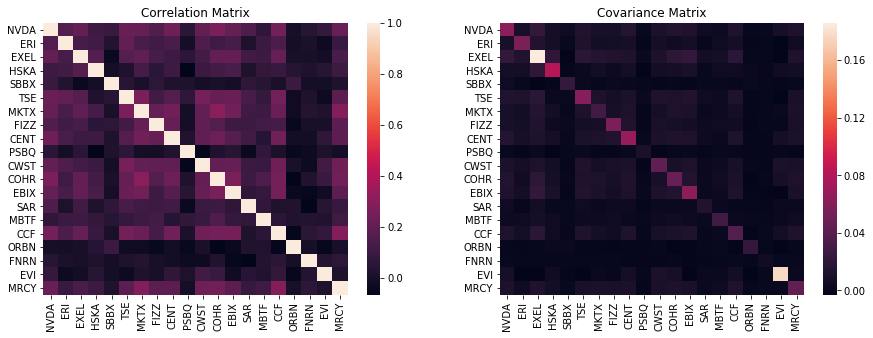

In [24]:

compare_stocks(top_zc_stocks)

Again, we calculate the efficient frontier and examine the allocations across portfolios. 

In this case, our optimal portfolio achieved a Sharpe ratio greater than 4.95 -- extremely impressive, especially considering no additional research went into the selection methodology. Moreover, our portfolio is well diversified across almost all 20 stocks based on our allocation plot. 

In [25]:
# Calculate the Markowitz efficient frontier 
zc_ef_results = optimal_portfolio(top_zc_stocks, train[top_zc_stocks].T.values)

# Extract the best portfolio from the frontier
best_zc_sharpe_index = np.argmax(zc_ef_results['sharpes'].values)
optimal_zc_weights = zc_ef_results.iloc[best_zc_sharpe_index].loc[top_zc_stocks]

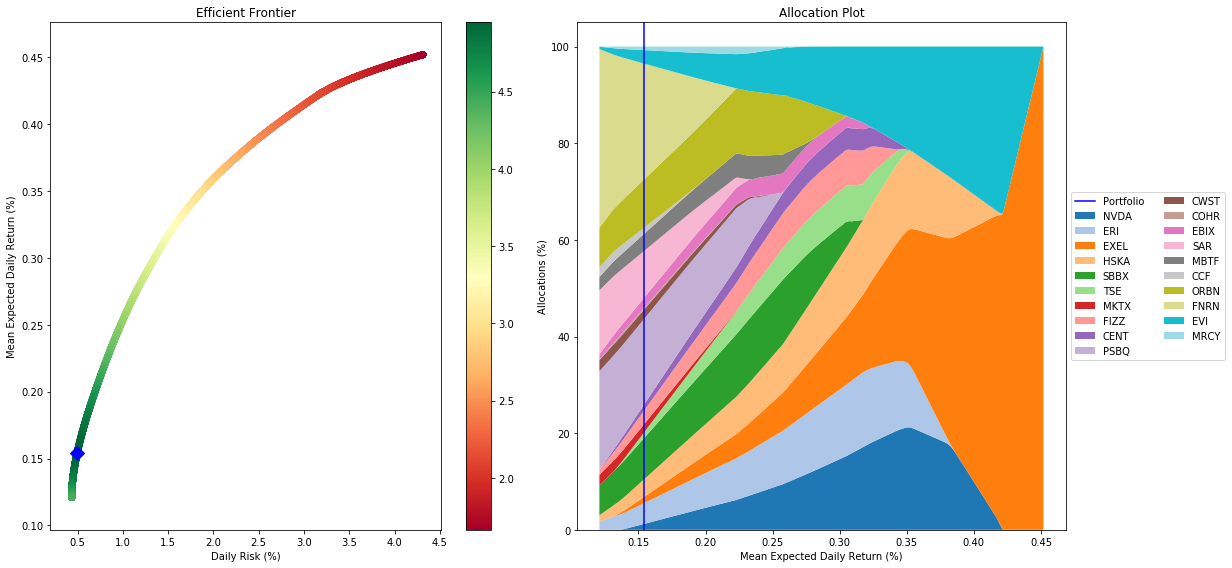

In [26]:
plot_simulations(zc_ef_results, best_zc_sharpe_index, top_zc_stocks)

In [27]:
# Calculate the one-day 99% value at risk and expected shortfall
zc_VaRs, zc_VaR, zc_ES = simulate_VaRs(top_zc_stocks, optimal_zc_weights, 10000)

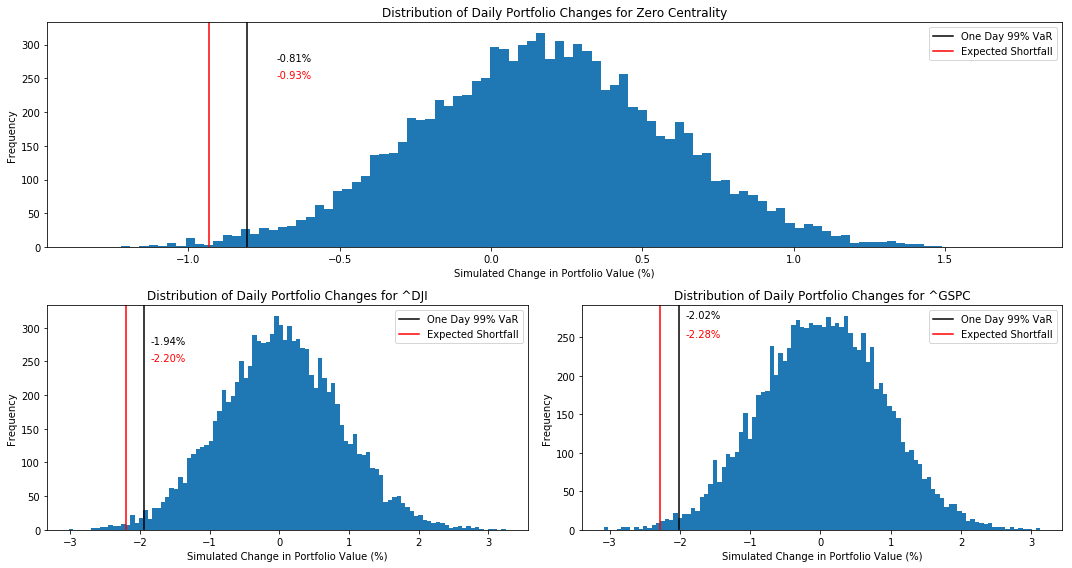

In [28]:
plot_VaRs('Zero Centrality', zc_VaRs, zc_VaR, zc_ES)

In [29]:
zc_portfolio = (test[top_zc_stocks] * optimal_zc_weights).sum(axis=1)
print("Alpha: " + str(calc_jensen(zc_portfolio, '^GSPC', benchmark_return)))
print("Beta: " + str(calc_beta(zc_portfolio, '^GSPC')))
print("Treynor Ratio: " + str(calc_treynor(zc_portfolio, '^GSPC', benchmark_return)))

Alpha: 15.103
Beta: 0.365
Treynor Ratio: 61.932
